In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import datetime

In [2]:
 #--- 1. Configuration and Parameters ---
LOOK_BACK_MINUTES = 60  # Number of past minutes to consider for prediction
PREDICTION_HORIZON_MINUTES = 5 # Predict price in the next 5 minutes
TRAIN_TEST_SPLIT_RATIO = 0.8 # 80% for training, 20% for testing
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 10 # For early stopping


In [3]:
# Check for CUDA (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# --- 2. Data Acquisition (Same as before) ---
def get_sp500_data(interval='5m', period='60d'):
    """
    Fetches S&P 500 (^GSPC) data using yfinance.
    Args:
        interval (str): Data interval (e.g., '1m', '5m', '1h'). Max 7 days for '1m'.
        period (str): Data period (e.g., '1d', '5d', '7d').
    Returns:
        pd.DataFrame: DataFrame with historical data.
    """
    print(f"Fetching S&P 500 data (interval: {interval}, period: {period})...")
    try:
        data = yf.download(tickers="^GSPC", interval=interval, period=period)
        if data.empty:
            print("No data fetched. Check ticker, interval, or period.")
            return None
        print("Data fetched successfully.")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [5]:
# --- 3. Data Preprocessing & Custom Dataset for PyTorch ---
class TimeSeriesDataset(Dataset):
    def __init__(self, data, look_back, prediction_horizon):
        self.data = data
        self.look_back = look_back
        self.prediction_horizon = prediction_horizon
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaled_data = self.scaler.fit_transform(data.reshape(-1, 1))

        self.X = []
        self.y = []
        for i in range(len(self.scaled_data) - self.look_back - self.prediction_horizon + 1):
            # Features: 'look_back' past prices
            self.X.append(self.scaled_data[i:(i + self.look_back), 0])
            # Target: Price 'prediction_horizon' into the future
            self.y.append(self.scaled_data[i + self.look_back + self.prediction_horizon - 1, 0])

        self.X = torch.tensor(np.array(self.X), dtype=torch.float32).unsqueeze(-1) # Add feature dimension
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32).unsqueeze(-1) # Keep as (samples, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# --- 4. Model Definition (LSTM in PyTorch) ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=2, dropout_rate=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate) # Additional dropout after LSTM output
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # input_seq shape: (batch_size, seq_len, input_size)
        # Initialize hidden state and cell state for the first time step
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        # lstm_out shape: (batch_size, seq_len, hidden_size)
        
        # Take the output from the last time step
        output = self.dropout(lstm_out[:, -1, :])
        predictions = self.linear(output)
        return predictions

In [7]:
# --- 5. Training and Prediction ---
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, patience, device):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    train_losses = []
    val_losses = []

    print("\nTraining LSTM model...")
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = loss_function(predictions, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval() # Set model to evaluation mode
        total_val_loss = 0
        with torch.no_grad(): # Disable gradient calculations during validation
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                predictions_val = model(batch_X_val)
                loss_val = loss_function(predictions_val, batch_y_val)
                total_val_loss += loss_val.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth') # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {patience} epochs without improvement.')
                break
    
    # Load the best model weights after training
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

def make_predictions(model, data_loader, scaler, device):
    model.eval() # Set model to evaluation mode
    all_predictions = []
    all_actuals = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            predictions = model(batch_X)
            all_predictions.extend(predictions.cpu().numpy())
            all_actuals.extend(batch_y.cpu().numpy())
            
    # Invert scaling
    predictions_original_scale = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
    actuals_original_scale = scaler.inverse_transform(np.array(all_actuals).reshape(-1, 1))
    
    return predictions_original_scale, actuals_original_scale


In [8]:
# --- 6. Visualization (Optional - same as before) ---
def plot_predictions(actual_train, actual_test, train_preds, test_preds,
                     look_back_minutes, prediction_horizon_minutes):
    """
    Plots the actual vs predicted prices.
    """
    plt.figure(figsize=(15, 7))
    plt.plot(actual_train, label='Actual Train Price')
    plt.plot(np.arange(len(train_preds), len(train_preds) + len(test_preds)), actual_test, label='Actual Test Price')
    plt.plot(train_preds, label='Predicted Train Price')
    plt.plot(np.arange(len(train_preds), len(train_preds) + len(test_preds)), test_preds, label='Predicted Test Price')
    plt.title(f'S&P 500 Price Prediction (PyTorch LSTM) - Next {prediction_horizon_minutes} minutes')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.show()

Fetching S&P 500 data (interval: 5m, period: 60d)...


C:\Users\MediMonster\AppData\Local\Temp\ipykernel_10384\2590382048.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers="^GSPC", interval=interval, period=period)
[*********************100%***********************]  1 of 1 completed


Data fetched successfully.
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

Training LSTM model...
Epoch 1/100, Train Loss: 0.014806, Val Loss: 0.005071
Epoch 2/100, Train Loss: 0.031615, Val Loss: 0.000780
Epoch 3/100, Train Loss: 0.029502, Val Loss: 0.000976
Epoch 4/100, Train Loss: 0.026762, Val Loss: 0.001085
Epoch 5/100, Train Loss: 0.020037, Val Loss: 0.002670
Epoch 6/100, Train Loss: 0.007091, Val Loss: 0.000364
Epoch 7/100, Train Loss: 0.004112, Val Loss: 0.000289
Epoch 8/100, Train Loss: 0.002427, Val Loss: 0.000224
Epoch 9/100, Train Loss: 0.001793, Val Loss: 0.000555
Epoch 10/100, Train Loss: 0.001693, Val Loss: 0.001109
Epoch 11/100, Train Loss: 0.001527, Val Loss: 0.000136
Epoch 12/100, Train Loss: 0.001594, Val Loss: 0.000128
Epoch 13/100, Train Loss: 0.001309, Val Loss: 0.000220
Epoch 14/100, Train Loss: 0.001380, Val Loss: 0.000200
Epo

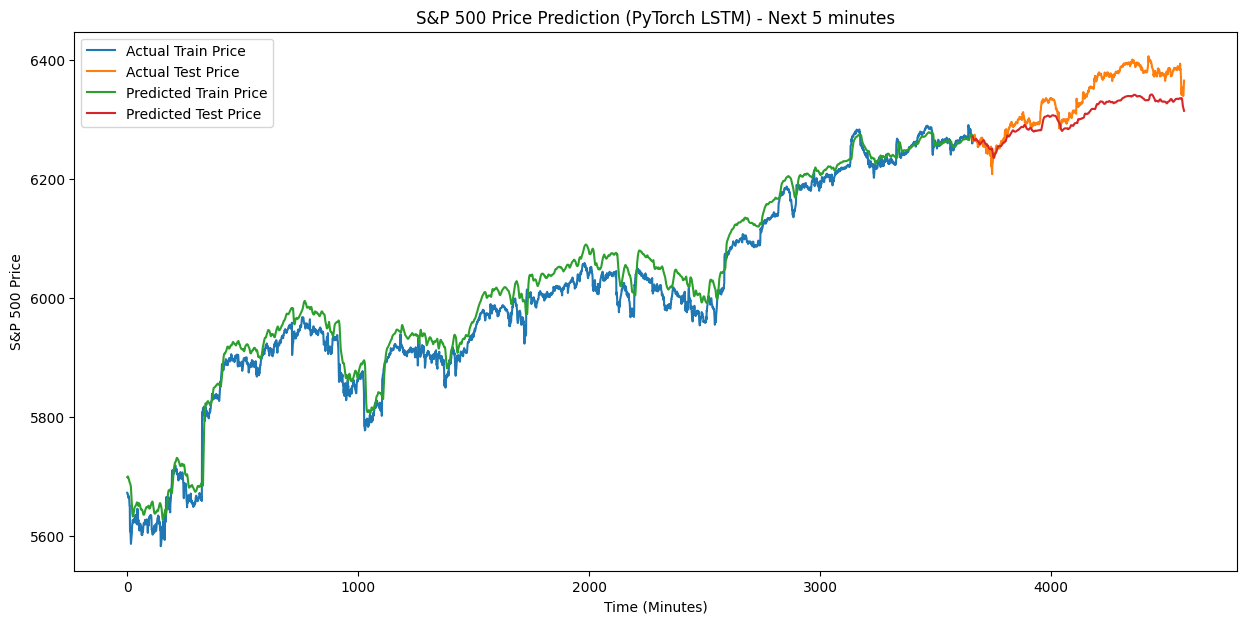

In [9]:
# --- Main Execution ---
if __name__ == "__main__":
    # 1. Get Data
    df = get_sp500_data(interval='5m', period='60d')
    if df is None or df.empty:
        print("Exiting: Could not retrieve sufficient data.")
        exit()

    df.sort_index(inplace=True)
    prices = df['Close'].values # Use values for direct numpy array

    # 2. Prepare Data & Create PyTorch Datasets/DataLoaders
    # The TimeSeriesDataset handles scaling and sequence creation internally
    full_dataset = TimeSeriesDataset(prices, LOOK_BACK_MINUTES, PREDICTION_HORIZON_MINUTES)
    
    # Split the dataset into training and testing indices
    train_size = int(len(full_dataset) * TRAIN_TEST_SPLIT_RATIO)
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size],
                                                                generator=torch.Generator().manual_seed(42))
    
    # Ensure correct sequential split for time series
    # Using manual split to maintain time order
    train_indices = list(range(train_size))
    test_indices = list(range(train_size, len(full_dataset)))

    train_subset = torch.utils.data.Subset(full_dataset, train_indices)
    test_subset = torch.utils.data.Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False) # Keep time order
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

    # For validation within training
    val_split_index = int(train_size * 0.9) # 90% of training for training, 10% for validation
    train_data_for_loader = torch.utils.data.Subset(full_dataset, train_indices[:val_split_index])
    val_data_for_loader = torch.utils.data.Subset(full_dataset, train_indices[val_split_index:train_size])

    train_loader_for_training = DataLoader(train_data_for_loader, batch_size=BATCH_SIZE, shuffle=False)
    val_loader_for_training = DataLoader(val_data_for_loader, batch_size=BATCH_SIZE, shuffle=False)

    # 3. Build Model
    model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1, num_layers=2).to(device)
    print(model)

    # 4. Train Model
    trained_model, train_losses_hist, val_losses_hist = train_model(model, train_loader_for_training, val_loader_for_training,
                                                                    NUM_EPOCHS, LEARNING_RATE, PATIENCE, device)

    # 5. Make Predictions
    print("\nMaking predictions on train and test sets...")
    train_predictions, actual_train_prices = make_predictions(trained_model, train_loader, full_dataset.scaler, device)
    test_predictions, actual_test_prices = make_predictions(trained_model, test_loader, full_dataset.scaler, device)

    # Predict the very next 5 minutes price
    # Get the last `LOOK_BACK_MINUTES` prices from the original scaled data
    last_sequence_scaled = full_dataset.scaled_data[-LOOK_BACK_MINUTES:].reshape(1, LOOK_BACK_MINUTES, 1)
    last_sequence_tensor = torch.tensor(last_sequence_scaled, dtype=torch.float32).to(device)
    
    trained_model.eval() # Set to eval mode for final prediction
    with torch.no_grad():
        next_5_min_prediction_scaled = trained_model(last_sequence_tensor).cpu().numpy()
    
    next_5_min_prediction = full_dataset.scaler.inverse_transform(next_5_min_prediction_scaled)[0][0]
    print(f"\nPredicted S&P 500 price in the next {PREDICTION_HORIZON_MINUTES} minutes: {next_5_min_prediction:.2f}")

    # 6. Visualize Results
    plot_predictions(actual_train_prices, actual_test_prices, train_predictions, test_predictions,
                     LOOK_BACK_MINUTES, PREDICTION_HORIZON_MINUTES)